# Data Profiling

In [1]:
import pandas as pd

file_path = "/content/drive/MyDrive/Digital Credit Scoring /Datasheet for DS.csv"

# Try latin1 first
df = pd.read_csv(file_path, encoding="latin1")

print("Rows:", df.shape[0], "| Columns:", df.shape[1])
df.head()

Rows: 800 | Columns: 15


,Name,Age,Gender,City,Degree,CGPA,Internship,Family Income,Scholarship,Loan Type,Bank Account,Subscriptions,Food Spend (â¹),Monthly Expenses (â¹),Savings Pattern
0,Aarav Sharma,21.0,Male,Pune,B.Tech,8.2,Yes (3 months),36L,Yes (?25000),Education Loan,Savings,"Netflix, Gym",1200.0,8500.0,Regular
1,Sneha Patil,22.0,Female,Mumbai,MBA,7.6,Yes (6 months),610L,No,No,Student,"Spotify, OTT",1800.0,9500.0,Occasional
2,Rohan Deshmukh,20.0,Male,Nagpur,B.Com,6.9,No,13L,Yes (?15000),No,Savings,"OTT, Gym",900.0,6000.0,NaN
3,Meera Joshi,23.0,Female,Nashik,M.Tech,9.1,Yes (4 months),1015L,No,Personal Loan,Joint,"Netflix, Spotify",2500.0,12000.0,Regular
4,Yash Kale,19.0,Male,Aurangabad,BCA,7.4,No,<1L,Yes (?10000),No,Student,OTT,700.0,4500.0,Occasional


# Cleaning and Mapping

Clean column names

In [2]:
# Clean column names safely
df.columns = df.columns.str.strip().str.replace(r"[^\w\s]", "", regex=True).str.replace(" ", "_")

print(df.columns.tolist())

['Name', 'Age', 'Gender', 'City', 'Degree', 'CGPA', 'Internship', 'Family_Income', 'Scholarship', 'Loan_Type', 'Bank_Account', 'Subscriptions', 'Food_Spend_â¹', 'Monthly_Expenses_â¹', 'Savings_Pattern']


Fix Family income mapping

In [3]:
income_map = {
    "<1L": 0.5e5, "1-3L": 2e5, "1–3L": 2e5, "13L": 2e5,
    "3-6L": 4.5e5, "3–6L": 4.5e5, "36L": 4.5e5,
    "6-10L": 8e5, "6–10L": 8e5, "610L": 8e5,
    "10-15L": 12.5e5, "10–15L": 12.5e5, "1015L": 12.5e5,
    "15-20L": 17.5e5, "15–20L": 17.5e5, "1520L": 17.5e5,
    ">20L": 22.5e5
}
df["Family_Income_Clean"] = df["Family_Income"].map(income_map)

Scholarship

In [4]:
import re

def parse_scholarship(x):
    if pd.isna(x) or str(x).strip() == "No":
        return 0
    amt = re.findall(r"\d+", str(x).replace(",", ""))
    return int(amt[0]) if amt else 0

df["Scholarship_Amount"] = df["Scholarship"].apply(parse_scholarship)
df["Has_Scholarship"] = (df["Scholarship_Amount"] > 0).astype(int)

Internship

In [5]:
def parse_internship(x):
    if "No" in str(x):
        return 0
    m = re.findall(r"\d+", str(x))
    return int(m[0]) if m else 0

df["Internship_Months"] = df["Internship"].apply(parse_internship)
df["Has_Internship"] = (df["Internship_Months"] > 0).astype(int)

In [6]:
df["Has_Loan"] = df["Loan_Type"].apply(lambda x: 0 if str(x)=="No" else 1)

In [7]:
df["Subscriptions_Count"] = df["Subscriptions"].fillna("").apply(lambda x: len(str(x).split(",")))

In [8]:
savings_map = {"Regular": 2, "Occasional": 1}
df["Savings_Score"] = df["Savings_Pattern"].map(savings_map).fillna(0)

Final Scoring

In [9]:
def compute_score(row):
    score = 0

    # CGPA
    if row["CGPA"] >= 9: score += 20
    elif row["CGPA"] >= 8: score += 15
    elif row["CGPA"] >= 7: score += 10
    elif row["CGPA"] >= 6: score += 5

    # Family Income
    if row["Family_Income_Clean"] >= 1000000: score += 20
    elif row["Family_Income_Clean"] >= 600000: score += 15
    elif row["Family_Income_Clean"] >= 300000: score += 10
    else: score += 5

    # Loan
    if row["Has_Loan"] == 0: score += 15
    elif "Education" in str(row["Loan_Type"]): score += 10
    else: score += 5

    # Savings Pattern
    score += row["Savings_Score"] * 5

    # Subscriptions
    if row["Subscriptions_Count"] <= 1: score += 10
    elif row["Subscriptions_Count"] == 2: score += 5

    # Expenses vs Income
    try:
        expenses = float(row.get("Food_Spend_",0)) + float(row.get("Monthly_Expenses_",0))
    except:
        expenses = 0
    ratio = expenses / (row["Family_Income_Clean"]+1)
    if ratio < 0.3: score += 15
    elif ratio < 0.6: score += 10
    else: score += 5

    # Internship
    if row["Has_Internship"]: score += 5

    # Scholarship
    if row["Has_Scholarship"]: score += 5

    return score

df["Credit_Score"] = df.apply(compute_score, axis=1)

In [10]:
df[["Name","CGPA","Family_Income","Loan_Type","Savings_Pattern",
    "Subscriptions","Has_Internship","Has_Scholarship","Credit_Score"]].head(10)

,Name,CGPA,Family_Income,Loan_Type,Savings_Pattern,Subscriptions,Has_Internship,Has_Scholarship,Credit_Score
0,Aarav Sharma,8.2,36L,Education Loan,Regular,"Netflix, Gym",1,1,75.0
1,Sneha Patil,7.6,610L,No,Occasional,"Spotify, OTT",1,0,70.0
2,Rohan Deshmukh,6.9,13L,No,NaN,"OTT, Gym",0,1,50.0
3,Meera Joshi,9.1,1015L,Personal Loan,Regular,"Netflix, Spotify",1,0,80.0
4,Yash Kale,7.4,<1L,No,Occasional,OTT,0,1,65.0
5,Priya More,8.0,36L,No,Regular,"Netflix, Gym",1,0,75.0
6,Aditya Pawar,7.2,13L,No,Occasional,"OTT, Spotify",1,1,65.0
7,Neha Jadhav,6.8,<1L,No,NaN,Gym,0,1,55.0
8,Kunal Shinde,8.5,610L,Personal Loan,Regular,"Netflix, OTT",1,0,70.0
9,Aishwarya Rane,7.9,36L,No,Regular,"Spotify, Gym",1,1,75.0


# Modelling

Define Risk Bucket

In [11]:
def risk_bucket(score):
    if score <= 50:
        return "High Risk"
    elif score <= 70:
        return "Medium Risk"
    else:
        return "Low Risk"

df["Risk_Bucket"] = df["Credit_Score"].apply(risk_bucket)
print(df["Risk_Bucket"].value_counts())

Risk_Bucket
Medium Risk    524
Low Risk       229
High Risk       47
Name: count, dtype: int64


Renaming Columns

In [12]:
df = df.rename(columns={
    "Food_Spend_â¹": "Food_Spend",
    "Monthly_Expenses_â¹": "Monthly_Expenses"
})

print(df.columns.tolist())

['Name', 'Age', 'Gender', 'City', 'Degree', 'CGPA', 'Internship', 'Family_Income', 'Scholarship', 'Loan_Type', 'Bank_Account', 'Subscriptions', 'Food_Spend', 'Monthly_Expenses', 'Savings_Pattern', 'Family_Income_Clean', 'Scholarship_Amount', 'Has_Scholarship', 'Internship_Months', 'Has_Internship', 'Has_Loan', 'Subscriptions_Count', 'Savings_Score', 'Credit_Score', 'Risk_Bucket']


Select Feature and Target

In [13]:
features = [
    "Age", "CGPA", "Family_Income_Clean", "Has_Loan",
    "Savings_Score", "Subscriptions_Count", "Food_Spend",
    "Monthly_Expenses", "Has_Internship", "Has_Scholarship"
]

X = df[features].fillna(0)
y = df["Risk_Bucket"]

Train and Test

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape, " Test size:", X_test.shape)

Train size: (640, 10)  Test size: (160, 10)


Train Models

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Logistic Regression with Scaling
lr = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=5000, random_state=42))
])
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

Logistic Regression
Accuracy: 0.98125
              precision    recall  f1-score   support

   High Risk       1.00      1.00      1.00         9
    Low Risk       0.96      0.98      0.97        46
 Medium Risk       0.99      0.98      0.99       105

    accuracy                           0.98       160
   macro avg       0.98      0.99      0.98       160
weighted avg       0.98      0.98      0.98       160



In [16]:
# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest
Accuracy: 0.9875
              precision    recall  f1-score   support

   High Risk       1.00      0.89      0.94         9
    Low Risk       0.98      1.00      0.99        46
 Medium Risk       0.99      0.99      0.99       105

    accuracy                           0.99       160
   macro avg       0.99      0.96      0.97       160
weighted avg       0.99      0.99      0.99       160



Feature Importance

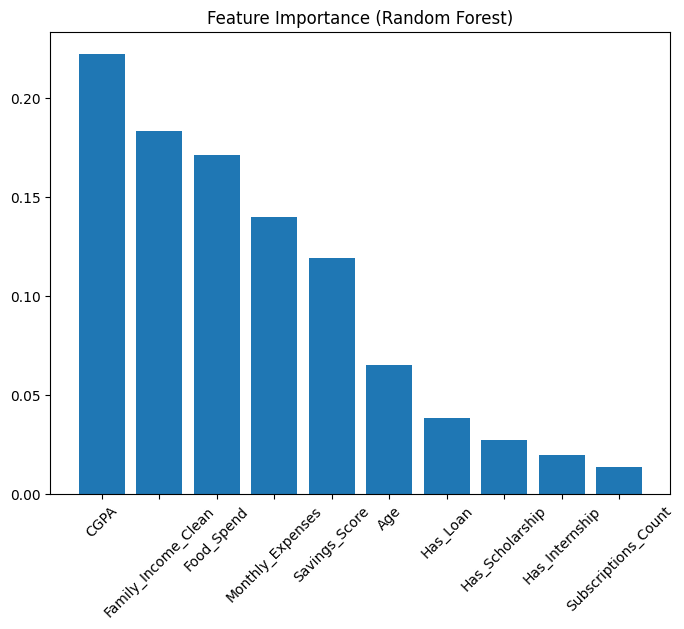

CGPA: 0.222
Family_Income_Clean: 0.183
Food_Spend: 0.171
Monthly_Expenses: 0.140
Savings_Score: 0.119
Age: 0.065
Has_Loan: 0.038
Has_Scholarship: 0.027
Has_Internship: 0.020
Subscriptions_Count: 0.014


In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importance
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(8,6))
plt.bar(range(len(features)), importances[indices], align="center")
plt.xticks(range(len(features)), [features[i] for i in indices], rotation=45)
plt.title("Feature Importance (Random Forest)")
plt.show()

# Print
for i in indices:
    print(f"{features[i]}: {importances[i]:.3f}")

# SHAP

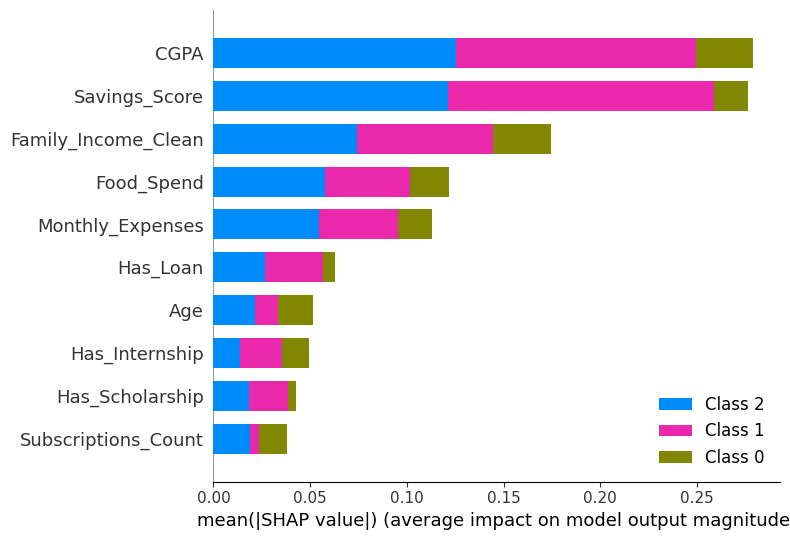

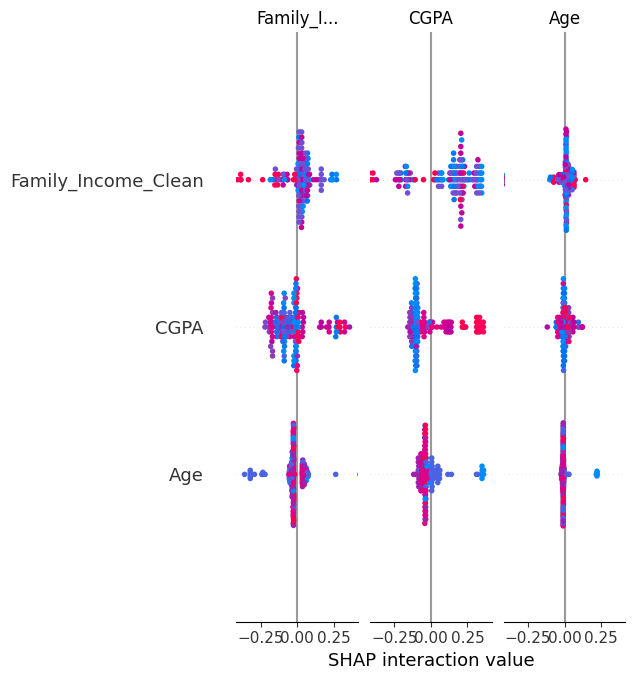

In [18]:
import shap

# Initialize SHAP explainer for Random Forest
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

# Summary Plot
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Detailed Summary Plot
shap.summary_plot(shap_values, X_test)

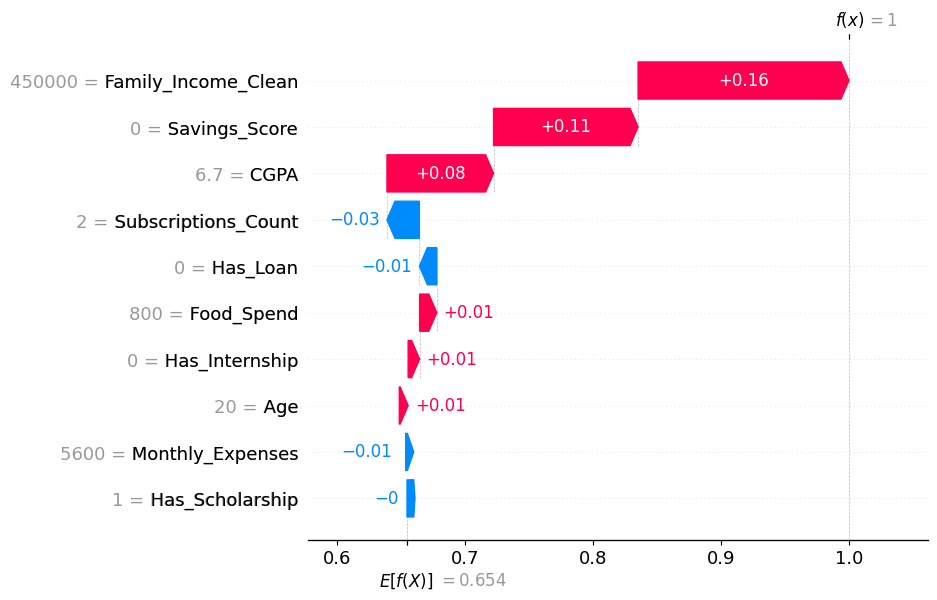

In [19]:
# Pick one student from the test set
sample_idx = 5

# Compute SHAP values for this student
shap_values_row = explainer(X_test.iloc[[sample_idx]])

# Get predicted class index for this student
pred_class = np.argmax(rf.predict_proba(X_test.iloc[[sample_idx]]))

# Plot waterfall for the predicted class only
shap.plots.waterfall(shap_values_row[0, :, pred_class])

# Credit Scoring Calibeartion

In [20]:
import numpy as np

def calibrate_score(probs, classes):

    # Define base scores for each bucket
    base_scores = {
        "High Risk": 300,
        "Medium Risk": 575,
        "Low Risk": 850
    }

    # Weighted average of base scores
    score = 0
    for i, c in enumerate(classes):
        score += probs[i] * base_scores[c]

    return round(score, 0)

# apply to test set
y_proba = rf.predict_proba(X_test)
calibrated_scores = [
    calibrate_score(probs, rf.classes_) for probs in y_proba
]

# Test DataFrame
results = X_test.copy()
results["True_Risk"] = y_test.values
results["Pred_Risk"] = rf.predict(X_test)
results["Credit_Score_300_850"] = calibrated_scores

results.head(10)

,Age,CGPA,Family_Income_Clean,Has_Loan,Savings_Score,Subscriptions_Count,Food_Spend,Monthly_Expenses,Has_Internship,Has_Scholarship,True_Risk,Pred_Risk,Credit_Score_300_850
143,21.0,7.6,50000.0,0,1.0,2,1200.0,7600.0,1,1,Medium Risk,Medium Risk,575.0
474,20.0,6.9,200000.0,0,0.0,2,850.0,5700.0,0,1,High Risk,High Risk,304.0
255,20.0,6.7,450000.0,0,0.0,2,800.0,5600.0,0,1,Medium Risk,Medium Risk,575.0
775,0.0,0.0,450000.0,1,0.0,1,0.0,0.0,0,1,High Risk,High Risk,300.0
3,23.0,9.1,1250000.0,1,2.0,2,2500.0,12000.0,1,0,Low Risk,Low Risk,850.0
83,20.0,6.7,450000.0,0,0.0,2,800.0,5600.0,0,1,Medium Risk,Medium Risk,575.0
222,21.0,7.6,800000.0,0,1.0,2,1200.0,7600.0,1,0,Medium Risk,Medium Risk,575.0
545,20.0,6.6,50000.0,0,0.0,2,850.0,5500.0,0,1,High Risk,Medium Risk,458.0
117,23.0,9.0,800000.0,1,2.0,2,2400.0,11500.0,1,0,Low Risk,Low Risk,850.0
301,22.0,8.9,800000.0,0,2.0,2,2200.0,10800.0,1,0,Low Risk,Low Risk,843.0


# Deployment Function

In [21]:
def get_credit_score(student_data, model, features, classes):

    import pandas as pd
    import numpy as np

    # Convert dict to DataFrame
    student_df = pd.DataFrame([student_data], columns=features)

    # Predict probabilities
    probs = model.predict_proba(student_df)[0]

    # Map risk bucket
    base_scores = {
        "High Risk": 300,
        "Medium Risk": 575,
        "Low Risk": 850
    }

    # Weighted average credit score
    credit_score = sum(probs[i] * base_scores[c] for i, c in enumerate(classes))
    credit_score = float(round(credit_score, 1))

    # Predicted class
    risk_bucket = model.predict(student_df)[0]

    # feature importances from Random Forest
    importances = model.feature_importances_
    sorted_idx = np.argsort(importances)[::-1]
    top_features = [(features[i], float(student_df.iloc[0, i])) for i in sorted_idx[:2]]

    return {
        "Risk_Bucket": risk_bucket,
        "Credit_Score": credit_score,
        "Top_Factors": top_features
    }

Example usage

In [22]:
# Example student data
new_student = {
    "Age": 21,
    "CGPA": 7.8,
    "Family_Income_Clean": 600000,
    "Has_Loan": 0,
    "Savings_Score": 1,
    "Subscriptions_Count": 2,
    "Food_Spend": 1200,
    "Monthly_Expenses": 7500,
    "Has_Internship": 1,
    "Has_Scholarship": 0
}

result = get_credit_score(new_student, rf, features, rf.classes_)
print(result)

{'Risk_Bucket': 'Medium Risk', 'Credit_Score': 575.0, 'Top_Factors': [('CGPA', 7.8), ('Family_Income_Clean', 600000.0)]}


# Streamlite App

In [23]:
!pip install streamlit
!pip install pyngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 64.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 84.2 MB/s eta 0:00:00


In [24]:
import streamlit as st
import pandas as pd
import joblib

In [25]:
joblib.dump(rf, "credit_model.pkl")
joblib.dump(features, "features.pkl")

print("Saved credit_model.pkl and features.pkl")

Saved credit_model.pkl and features.pkl


# Save Processed Files

In [26]:
from google.colab import files

# Save processed dataset
df.to_csv("processed_student_data.csv", index=False)

# Download files
files.download("processed_student_data.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>